In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.8 MB/s 


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, Callback
import PIL
import warnings
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import rasterio
import glob
import sklearn
import tensorflow as tf

In [ ]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='softmax', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model
unet = model_build_func(input_shape = (256,256,6), n_labels = 2)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1760        input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 1024        conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from keras import backend as K
def wcceloss(y_true, y_pred):

    weights = np.array([0.5,2.5])
    weights = K.constant(weights)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * weights
    loss = 1-K.sum(loss,axis= -1)
    #print(loss.shape)

    return loss

color_dict = {0: (0),
              1: (255),
              }

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:3]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,:,i] = np.all(rgb_arr == color_dict[i], axis=3).reshape(shape[:3])
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return output

def adjustData(img1, img2, mask):
  onehot=rgb_to_onehot(mask,color_dict)
  #onehot=np.reshape(onehot,((1,)+onehot.shape))
  #print(img1.shape,img2.shape,onehot.shape)
  img1 = img1/255
  img2 = img2/255
  #print(img1.shape,img2.shape,onehot.shape)
  return(img1, img2, onehot)
  


def TrainGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/train/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/train/B',
      target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/train/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1, img2), axis=3)
        img =tf.cast(img,tf.float32)
        mask =tf.cast(mask,tf.float32)
        #print(img.shape)
        #print(mask.shape)
        yield img,mask

def ValGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/val/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/B',
      target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1, img2), axis=3)
        img =tf.cast(img,tf.float32)
        mask =tf.cast(mask,tf.float32)
        #print(img.shape)
        #print(mask.shape)
        yield img,mask

def TestGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/pred/A',
       target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/pred/B',
      target_size = (256,256),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/pred/label',
      target_size = (256,256),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        img = np.concatenate((img1, img2), axis=3)
        img =tf.cast(img,tf.float32)
        mask =tf.cast(mask,tf.float32)
        #print(img.shape)
        #print(mask.shape)
        yield img,mask


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
path_of_training = '/content/drive/MyDrive/Levir-CD/train'
path_of_val = '/content/drive/MyDrive/Levir-CD/val'

data_gen_args = dict()

Generator = TrainGenerator(aug_dict=data_gen_args, train_path=path_of_training, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
Val = ValGenerator(aug_dict=data_gen_args, train_path=path_of_val, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None) 
#weights = np.array([0.5,2,10])

unet.compile(optimizer = Adam(learning_rate = 0.0001), loss="binary_crossentropy" , metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = unet.fit(Generator,validation_data = Val,validation_steps=128,steps_per_epoch=512,epochs=30,callbacks=[es,mc])
unet.save("/content/")

Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Epoch 1/30
512/512 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9525Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
512/512 [==============================] - 1556s 3s/step - loss: 0.1975 - accuracy: 0.9525 - val_loss: 0.3383 - val_accuracy: 0.9582

Epoch 00001: val_accuracy improved from -inf to 0.95820, saving model to best_model.h5
Epoch 2/30
512/512 [==============================] - 111s 216ms/step - loss: 0.1380 - accuracy: 0.9536 - val_loss: 0.1274 - val_accuracy: 0.9587

Epoch 00002: val_accuracy improved from 0.95820 to 0.95869, saving model to best_model.h5
Epoch 3/30
512/512 [==============================] - 110s 215ms/step - loss: 0.1129 - accuracy: 0.9619 - val_loss: 0.0953 - val_accuracy: 0.9713

Epoch 00003: val_accuracy improved from 0.95869 to 0.9713

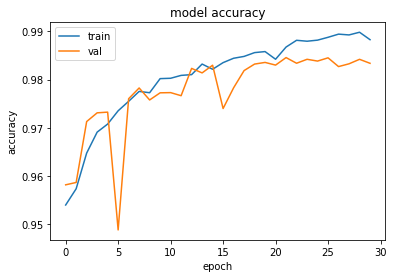

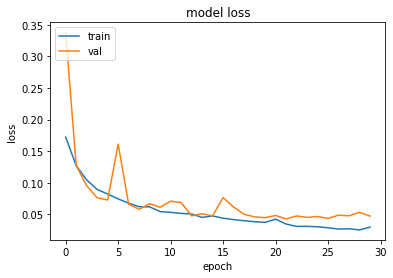

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/best_model.h5')
model.load_weights('/content/best_model.h5')
t = next(Val)
x_val = t[0]
y_val = t[1]
model.evaluate(x_val,y_val, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.0468 - accuracy: 0.9828


[0.04679414629936218, 0.982757568359375]

In [ ]:
path_of_testing = '/content/drive/MyDrive/Levir-CD/pred'
Generator= TestGenerator(aug_dict=data_gen_args, train_path=path_of_testing, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
t = next(Generator)
X_train = t[0]
Y_train = t[1]
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 85ms/step


In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
print(preds_train_t.shape)

(1, 256, 256, 2)


In [ ]:
color_dict = {0: 0,1: 255,}
def onehot_to_rgb(onehot, color_dict):
    print(onehot.shape)
    single_layer = np.argmax(onehot, axis=3)
    print(single_layer.shape)
    output = np.zeros(onehot.shape[:3]+(3,) )
    print(output.shape)
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)
a = onehot_to_rgb(preds_train_t,color_dict)
y_pred_img = a

(1, 512, 512, 2)
(1, 512, 512)
(1, 512, 512, 3)


In [ ]:
from PIL import Image as im

a.reshape(512,512,3)
print(a.shape)
data = im.fromarray(a[0])
data.save('gfg_d.png')

(1, 512, 512, 3)


A:


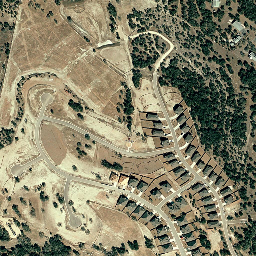

B:


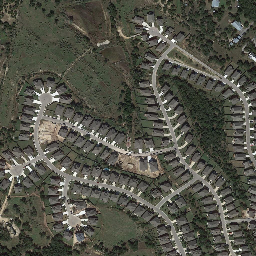

gt:


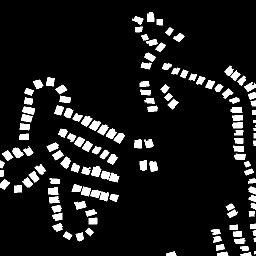

predicted:


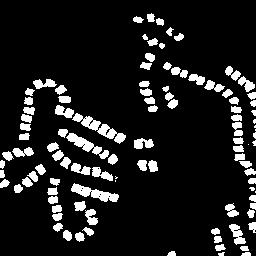

In [ ]:
from google.colab.patches import cv2_imshow
A = cv2.imread('/content/drive/MyDrive/changedetection/dataset/pred/A/A/Copy of test_7.png', cv2.IMREAD_UNCHANGED)
B = cv2.imread('/content/drive/MyDrive/changedetection/dataset/pred/B/B/Copy of test_7.png', cv2.IMREAD_UNCHANGED)
gt = cv2.imread('/content/drive/MyDrive/changedetection/dataset/pred/label/label/Copy of test_7.png', cv2.IMREAD_UNCHANGED)
pr = cv2.imread('/content/gfg_d.png', cv2.IMREAD_UNCHANGED)
A = cv2.resize(A,(256,256))
B = cv2.resize(B,(256,256))
gt = cv2.resize(gt,(256,256))
print('A:')
cv2_imshow(A)
print('B:')
cv2_imshow(B)
print('gt:')
cv2_imshow(gt)
print('predicted:')
cv2_imshow(pr)

In [ ]:
from PIL import Image
_,h, w, c = preds_train.shape
preds_train = np.reshape(preds_train, (h, w, c))

img = preds_train
h, w, c = img.shape
color_dict = {0: (0),
              1: (255),
              }
# Generate one hot encoded array from predicted output.
for i in range(h):
    for j in range(w):
        # Select the index of max value among the 9 classes.
        argmax_index = np.argmax(img[i, j])
        onehot_arr = np.zeros((2))
        onehot_arr[argmax_index] = 1
        img[i, j, :] = onehot_arr

# Convert OneHotEncoded array to RGB.
def onehot_to_rgb(onehot, color_dict):
    print(onehot.shape)
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,) )
    print(output.shape)
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)
  
y_pred_img = onehot_to_rgb(img,color_dict)

# Get the dimensions of the original image
h, w = 1024,1024

# Generate image and save it.
y_pred_img = y_pred_img[:h, :w, :]
imx = Image.fromarray(y_pred_img)
# Set file path appropriately
imx.save("/content/"+str(1) + "dddddd.jpg")
print("Saved...")

(256, 256, 2)
(256, 256, 3)
Saved...
